# Self-Driving Car Engineer Nanodegree

## Project: **Finding Lane Lines on the Road** 

The goals of this project are:

- Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
- Apply a distortion correction to raw images.
- Use color transforms, gradients, etc., to create a thresholded binary image.
- Apply a perspective transform to rectify binary image ("birds-eye view").
- Detect lane pixels and fit to find the lane boundary.
- Determine the curvature of the lane and vehicle position with respect to center.
- Warp the detected lane boundaries back onto the original image.
- Output visual display of the lane boundaries and numerical estimations of lane curvature and vehicle position.

##  [PART 0/3] General setup
---

### Import dependencies

In [1]:
# General dependencies for the image processing
import numpy as np
import time
import cv2
import glob
import matplotlib.pyplot as plt
%matplotlib qt

# Dependencies to edit/save/watch videos
from moviepy.editor import VideoFileClip
from IPython.display import HTML

### List of calibration images

In [2]:
# List of calibration images
calibration_images = glob.glob('camera_cal/calibration*.jpg')
n_calib_imgs = len(calibration_images)
print(str(n_calib_imgs) + ' detected images for calibration: ' + str(calibration_images))
print('')

20 detected images for calibration: ['camera_cal/calibration9.jpg', 'camera_cal/calibration15.jpg', 'camera_cal/calibration10.jpg', 'camera_cal/calibration12.jpg', 'camera_cal/calibration4.jpg', 'camera_cal/calibration17.jpg', 'camera_cal/calibration7.jpg', 'camera_cal/calibration5.jpg', 'camera_cal/calibration1.jpg', 'camera_cal/calibration20.jpg', 'camera_cal/calibration19.jpg', 'camera_cal/calibration8.jpg', 'camera_cal/calibration11.jpg', 'camera_cal/calibration14.jpg', 'camera_cal/calibration13.jpg', 'camera_cal/calibration18.jpg', 'camera_cal/calibration16.jpg', 'camera_cal/calibration6.jpg', 'camera_cal/calibration3.jpg', 'camera_cal/calibration2.jpg']



## [PART 1/3] Camera calibration
---
### General setup

In [3]:
# Amount of inner corners in each axis
nx = 9
ny = 6

# Prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
objp = np.zeros((nx*ny, 3), np.float32)
objp[:,:2] = np.mgrid[0:9, 0:6].T.reshape(-1, 2)

# Arrays to store object points and image points from all the images.
objpoints = [] # 3d points in real world space
imgpoints = [] # 2d points in image plane.

### Get image points, calibrate camera and show a sample undistortion

Camera matrix:
[[  1.15777818e+03   0.00000000e+00   6.67113857e+02]
 [  0.00000000e+00   1.15282217e+03   3.86124583e+02]
 [  0.00000000e+00   0.00000000e+00   1.00000000e+00]]

Distortion coefficients:
[[-0.24688507 -0.02373155 -0.00109831  0.00035107 -0.00259866]]


Text(0.5,1,'Undistorted image')

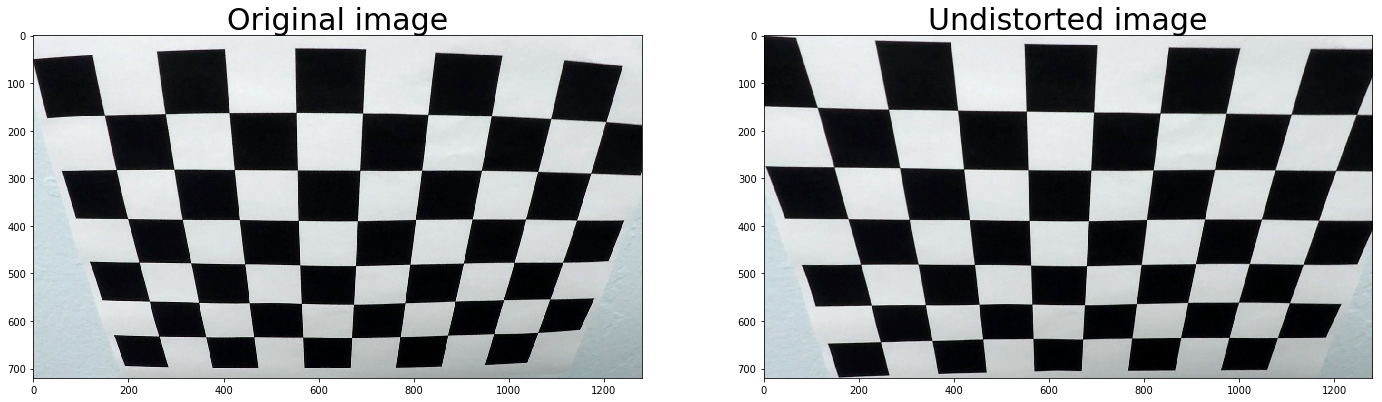

In [4]:
# Step through the list and search for chessboard corners
for fname in calibration_images:
    img = cv2.imread(fname)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (nx,ny), None)

    # If found, add object points, image points
    if ret == True:
        objpoints.append(objp)
        imgpoints.append(corners)

# Get camera matrix (mtx) and distortion coefficients (dist)
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1], None, None)
print('Camera matrix:')
print(mtx)
print('')
print('Distortion coefficients:')
print(dist)

# Display a sample undistortion with the last calibration image
# Read last image
img = cv2.imread(calibration_images[n_calib_imgs-1])

# Undistort image
undist = cv2.undistort(img, mtx, dist, None, mtx)

# Divide plot and show a sample result
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9)) 
ax1.imshow(img)
ax1.set_title('Original image', fontsize=30)
ax2.imshow(undist)
ax2.set_title('Undistorted image', fontsize=30)

##  [PART 2/3] Function declarations
---
### Image undistortion

In [5]:
def undistort(img, mtx, dist):
    """
    Undistorts the inputted image.
    
    ::arg mtx:: Camera matrix 
    ::arg dist:: Distortion parameters
    
    ::return:: Undistorted image (np.array)
    """
    return cv2.undistort(img, mtx, dist, None, mtx)

### Color and gradient filtering

In [6]:
def bin_mask_with_thresh(mask, thresh):
    """
    Creates a binary mask thresholding the input gradient response.
    
    ::arg mask:: Gryscale mask to be thresholded.
    ::arg thresh:: Threshold to be applied. Tuple in the format '(min, max)'.
    """
    
    bin_mask = np.zeros_like(mask)
    bin_mask[(mask > thresh[0]) & (mask < thresh[1])] = 1
    
    return bin_mask
    

def abs_sobel_thresh(gray, orient='x', sobel_kernel=3, thresh=(0, 255)):
    """ 
    Applies Sobel x or y, then takes an absolute value and thresholds.
    
    ::arg gray:: Grayscale image to filter.
    ::arg orient:: Orientation of the Sobel operator ('x' or 'y').
    ::arg sobel_kernel:: Size of the convolution. '3' will produce a 3x3 operator.
    ::arg thresh:: Threshold to be applied. Tuple in the format '(min, max)'.
    """

    # Take the derivative in x or y given orient = 'x' or 'y'
    sobel = cv2.Sobel(gray, cv2.CV_64F, orient=='x', orient=='y', ksize=sobel_kernel)

    # Take the absolute value of the derivative or gradient
    abs_sobel = np.absolute(sobel)

    # Scale to 8-bit (0 - 255) then convert to type = np.uint8
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))

    # Create a mask thresholding the scaled gradient
    return bin_mask_with_thresh(scaled_sobel, thresh)


def mag_thresh(gray, sobel_kernel=3, thresh=(0, 255)):
    """ 
    Applies Sobel x and y, then computes the magnitude of the gradient and thresholds.
    
    ::arg gray:: Grayscale image to filter.
    ::arg sobel_kernel:: Size of the convolution. '3' will produce a 3x3 operator.
    ::arg thresh:: Threshold to be applied. Tuple in the format '(min, max)'.
    """

    # Take the gradient in x and y separately
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)

    # Calculate the magnitude
    mag = np.sqrt(sobelx**2 + sobely**2)

    # Scale to 8-bit (0 - 255) then convert to type = np.uint8
    scale = np.max(mag)/255
    scaled_mag = (mag/scale).astype(np.uint8)

    # Create a mask thresholding the scaled gradient magnitude
    return bin_mask_with_thresh(scaled_mag, thresh)


def dir_threshold(gray, sobel_kernel=3, thresh=(0, np.pi/2)):
    """
    Applies Sobel x and y, then computes the direction of the gradient and thresholds.
    
    ::arg gray:: Grayscale image to filter.
    ::arg sobel_kernel:: Size of the convolution. '3' will produce a 3x3 operator.
    ::arg thresh:: Threshold to be applied. Tuple in the format '(min, max)' in radians.
    """

    # Gradients in x and y
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)

    # Absolute values of the x and y gradients
    abs_sobelx = np.absolute(sobelx)
    abs_sobely = np.absolute(sobely)

    # Calculate the direction of the gradient 
    direction = np.arctan2(abs_sobely, abs_sobelx)

    # Create a mask thresholding the gradient direction
    return bin_mask_with_thresh(direction, thresh)



def apply_double_thresholding(img, s_thresh=(170, 255), sx_thresh=(20,100) , sy_thresh=(20,100), sm_thresh=(30,100), sd_thresh=(0.7,1.3)):
    """
    Applies several thresholds to the input image to output a binary mask.
    The thresholds are applied in the S channel of the HLS color space,
    in the X and Y gradients and in the gradient magnitude and direction.
    
    ::arg img:: (Undistorted) image in which the thresholds will be applied.
    ::arg s_thresh:: Threshold for the S channel from HLS.
    ::arg sx_thresh:: Sobel X threshold.
    ::arg sy_thresh:: Sobel Y thresh.
    ::arg sm_thresh:: Sobel magnitude thresh.
    ::arg sd_thresh:: Sobel direction thresh.
    """
    
    # Convert to HLS color space and separate the V channel
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    h_channel = hls[:,:,0] # Color channel
    l_channel = hls[:,:,1] # Lightness/grayscale channel
    s_channel = hls[:,:,2] # Saturation channel

    #Apply Sobels
    gradx = abs_sobel_thresh(l_channel, orient='x', sobel_kernel=3, thresh=sx_thresh)
    grady = abs_sobel_thresh(l_channel, orient='y', sobel_kernel=3, thresh=sy_thresh)
    mag_binary = mag_thresh(l_channel, sobel_kernel=3, thresh=sm_thresh)
    dir_binary = dir_threshold(l_channel, sobel_kernel=15, thresh=sd_thresh)
    
    #Combine Sobel's binary outputs
    sobel_combined = np.zeros_like(dir_binary)
    sobel_combined[((gradx == 1) & (grady == 1)) | ((mag_binary == 1) & (dir_binary == 1))] = 1

    # Threshold color channel
    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel > s_thresh[0]) & (s_channel < s_thresh[1])] = 1 

    # This provides a 3 channel image showing which pixels have been activated by gradient or color.
    #it was commented because it is unnecesary, but it can be relevant to visualize it for fine-tuning.
    ## Stack each channel and append to the list
    ## sobel_and_s_binary=np.dstack((np.zeros_like(s_channel), sobel_combined, s_binary))
    
    # Create black and white version
    binary_bw = (sobel_combined == 1) | (s_binary == 1)
    
    
    return binary_bw

### Perspective transformation or *warping*

In [7]:
def warp_image(img, ysize, xsize):
    """
    Warps the input image to get a top-down view of the lane.
    
    ::arg img:: (Binary double-thresholded) image to be warped.
    ::arg ysize:: Height (in pixels) of the input image.
    ::arg xsize:: Width (in pixels) of the input image.
    
    ::return:: Returns the warped image and the transformation matrix
    needed to revert the performed transformation (M_inv).
    """

    # Set the source reference points for the transformation
    src_1 = [0, ysize]
    src_2 = [int(0.4*xsize), int(0.65*ysize)]
    src_3 = [int(0.6*xsize), int(0.65*ysize)]
    src_4 = [xsize, ysize]

    src = np.float32([src_1, src_2, src_3, src_4])

    # Set the destination reference points (image reduced 100 pixels)
    xsize2 = xsize-100
    ysize2 = ysize-100
    
    dst_1 = [100, ysize2]
    dst_2 = [100, 100]
    dst_3 = [xsize2, 100]
    dst_4 = [xsize2, ysize2]

    dst = np.float32([dst_1, dst_2, dst_3, dst_4])

    # Compute transformation matrix and the one to perform the oposite transformation
    M = cv2.getPerspectiveTransform(src, dst)
    M_inv = cv2.getPerspectiveTransform(dst, src)

    # Warp the image and append to the list of warped/transformed images
    warped_img = cv2.warpPerspective(img.astype(np.uint8), M, (xsize, ysize), flags=cv2.INTER_LINEAR)
    
    return warped_img, M_inv

### Sliding window and polynomial fitting

In [8]:
def find_lane_pixels(binary_warped, ysize, nwindows, margin, minpix):
    """
    Identify which pixels correspond to which lane line using sliding windows
    initialised by a histogram prior.
    
    ::arg binary_warped:: (Binary warped) image to be processed.
    ::arg nwindows:: Number of windows (used in the Y axis).
    ::arg margin:: Windows' width (in pixels).
    ::arg minpix:: Minimum ammount of pixels contained in the window to displace the window.
    """
    # Take a histogram of the bottom half of the image
    histogram = np.sum(binary_warped[ysize//2:,:], axis=0)
    # Create an output image to draw on and visualize the result
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))
    # Find the peaks of the left and right halves of the histogram (starts of lane lines)
    midpoint = np.int(histogram.shape[0]//2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # Set height of windows - based on nwindows above and image shape
    window_height = np.int(ysize//nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated later for each window in nwindows
    leftx_current = leftx_base
    rightx_current = rightx_base

    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = ysize - (window+1)*window_height
        win_y_high = ysize - window*window_height
        ### Find the four below boundaries of the window ###
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin

        # Draw the windows on the visualization image
        cv2.rectangle(out_img, (win_xleft_low,win_y_low), (win_xleft_high,win_y_high),(0,255,0), 2)
        cv2.rectangle(out_img, (win_xright_low,win_y_low), (win_xright_high,win_y_high),(0,255,0), 2)

        ### Identify the nonzero pixels in x and y within the window ###
        # Crop current window
        nonzero_left = (nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & \
        (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)
        nonzero_right = (nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & \
        (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)
        # Get nonzero indices
        good_left_inds = nonzero_left.nonzero()[0]
        good_right_inds = nonzero_right.nonzero()[0]

        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)

        ### If good_inds > minpix pixels are, recenter next window on their mean position ###
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.array(nonzerox[good_left_inds]).mean())
        if len(good_right_inds) > minpix:
            rightx_current = np.int(np.array(nonzerox[good_right_inds]).mean())
            
    # Concatenate the arrays of indices (previously was a list of lists of pixels)
    try:
        left_lane_inds = np.concatenate(left_lane_inds)
        right_lane_inds = np.concatenate(right_lane_inds)
    except ValueError:
        # Avoids an error if the above is not implemented fully
        pass

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds]
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]

    return leftx, lefty, rightx, righty, out_img


def fit_polynomial(img, ysize, nwindows=9, margin=100, minpix=50):
    """
    Fits a second order polynomial to the two main vertical(ish) lines in the
    inputted (binary warped) image and returns a visualization of it.
    
    ::arg binary_warped:: (Binary warped) image to be processed.
    ::arg nwindows:: Number of windows (used in the Y axis) used in the lane search.
    ::arg margin:: Width of the windows (in pixels) used in the lane search.
    ::arg minpix:: Minimum ammount of pixels contained in the window to displace the
    windows of the lane search.
    """
    
    # Find our lane pixels first
    leftx, lefty, rightx, righty, poly_img = find_lane_pixels(img, ysize, nwindows, margin, minpix)

    ### Fit a second order polynomial to each ###
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)

    ## Visualization ##
    # Colors in the left and right lane regions
    poly_img[lefty, leftx] = [255, 0, 0]
    poly_img[righty, rightx] = [0, 0, 255]
    
    # Sample polynomial
    ploty = np.linspace(0, img.shape[0]-1, img.shape[0])
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

    # Draw fitted polynomial into image
    for idx, y in enumerate(ploty):
        poly_img = cv2.circle(poly_img, (int(left_fitx[idx]), int(y)), 1, (255,255,0), 2) # Draw left sample
        poly_img = cv2.circle(poly_img, (int(right_fitx[idx]), int(y)), 1, (255,255,0), 2) # Right sample
    
    # TODO: MOVING MEAN FOR EACH COEFFICIENT
    
    return left_fit, right_fit, poly_img

### Curve radius and car's relative position

In [9]:
def get_radius_and_pose(left_fit, right_fit, xsize, lane_length=30, warped_y=720, lane_width=3.7, warped_x=700):
    """
    Computes the radius of the polynomial adjusted to each lane and the car pose (relative to the lane center).
    
    ::arg left_fit:: Polynomial fitted to the left lane line.
    ::arg right_fit:: Polynomial fitted to the right lane line.
    ::arg lane_length:: Approximation of the lane contained in the RoI (warped image section).
    Default value stablished according US regulations.
    ::arg warped_y:: Height of the warped image.
    ::arg lane_width:: Approximation of the lane width. Default value stablished according US regulations.
    ::arg warped_x:: Width of the warped image.
    
    ::return:: The left and right radius and the car position. All in meters. The position will be
    negative when the car is more on the left side of the lane.
    """
    
    ## COMMON SETUP
    # Define conversions in x and y from pixels space to meters
    ym_per_pix = lane_length/warped_y # meters per pixel in y dimension (lane length in meters and pixels)
    xm_per_pix = lane_width/warped_x # meters per pixel in x dimension (lane width in meters and pixels)
    
    # Get y and x coordinates of points
    ploty = np.linspace(0, warped_x-1, warped_x)
    
    
    ## RADIUS COMPUTATION ##
    # Define y-value where we want radius of curvature (maximum -> image bottom)
    y_eval = np.max(ploty)*ym_per_pix
    
    # Calculation of the radius of curvature
    Al = left_fit[0]
    Bl = left_fit[1]
    Cl = left_fit[2]
    left_rad = ((1+(2*Al*y_eval+Bl)**2)**1.5)/np.absolute(2*Al) ## Left curve radius
    Ar = right_fit[0]
    Br = right_fit[1]
    Cr = right_fit[2]
    right_rad = ((1+(2*Ar*y_eval+Br)**2)**1.5)/np.absolute(2*Ar) ## Right radius

    
    ## RELATIVE CAR POSITION COMPUTATION ##
    l_points = np.stack((left_fit[0]*(ploty**2) + left_fit[1]*ploty + left_fit[2], ploty)).astype(np.int).T

    # X position of the left lane line
    l_x = l_points[np.max(l_points[:, 1])][0]
    
    # Car position relative to the left lane lines
    rel_pos_l = lane_width - np.absolute((xsize// 2 - l_x) * xm_per_pix)
    
    # Car position relative to the lane center
    rel_pos = rel_pos_l - (lane_width/2)
    
    return left_rad, right_rad, rel_pos

### Inverse lane warping

In [10]:
def reverse_lane_warping(img, left_fit, right_fit, xsize, ysize, M_inv):
    """
    Draws a filled polygon in the warped plane and reprojects and merges it with the original image.
    
    ::arg img:: (Undistorted) original image in which the lane projection will be done.
    ::arg left_fit:: Polynomial fitted to the left lane line.
    ::arg right_fit:: Polynomial fitted to the left lane line.
    ::arg xsize:: Width (in pixels) of the original image.
    ::arg ysize:: Height (in pixels) of the original image.
    ::arg M_inv:: Transformation matrix to project pixels from the warped plane into the original one.
    
    ::return:: Inputted image with the lane reprojection on it.
    """
    
    # Black canvas image-like to draw the lane on it
    lane_mask = np.zeros_like(img)
    
    # Sample the left lane line polynomial
    ploty = np.linspace(0, ysize-1, ysize)
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]

    # Sample the right poly
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

    # Create list with all the points
    left_samples = np.swapaxes(np.array([left_fitx, ploty]), 0, 1)
    right_samples = np.swapaxes(np.array([right_fitx, ploty]), 0, 1)
    right_samples_inv = np.flip(right_samples, 0) # Flip to draw the points in the correct order 
    vertices = np.concatenate((left_samples, right_samples_inv))
    vertices = np.array([vertices], dtype=np.int32)
    
    # Create a green polygon into the black canvas
    cv2.fillPoly(lane_mask, vertices, (0, 255, 0))
    
    # Apply inverse transformation to black canvas to unwarp the polygon
    lane_mask = cv2.warpPerspective(lane_mask, M_inv, (xsize, ysize))
    
    # Add transformed mask to original image (with some transparency)
    trans = 0.7
    img = cv2.addWeighted(img, trans, lane_mask, 1-trans, 0)
    
    return img

### Output frame composition

In [11]:
def compose_output_frame(img, poly_img, left_rad, right_rad, rel_pos, xsize, ysize):
    # Define auxiliar image size (to rescale poly_img)
    ysize2 = ysize//3
    xsize2 = xsize//3
    
    
    ## Add texts
    # Prepare text to write in main view (using 2 decimals)
    mean_rad = (left_rad + right_rad)/2
    position_txt = 'Distance to lane center: ' + str("%.2f" % (rel_pos*100)) + ' cm'
    radius_txt = 'Curvature radius: ' + str("%.2f" % (mean_rad/1000)) + ' km'
    
    # Write text on top of the image (white)
    cv2.putText(img, position_txt, (10,50), cv2.FONT_HERSHEY_SIMPLEX, 1, (255,255,255), 2)
    cv2.putText(img, radius_txt, (10,100), cv2.FONT_HERSHEY_SIMPLEX, 1, (255,255,255), 2)
    
    # Title to secondary view (yellow)
    cv2.putText(poly_img, 'Top-down transformed view', (10,50), cv2.FONT_HERSHEY_SIMPLEX, 1, (255,255,0), 2)
    
    
    ## Add RoIs to image (red)
    # Main view
    roi_1 = (0, ysize)
    roi_2 = (int(0.4*xsize), int(0.65*ysize))
    roi_3 = (int(0.6*xsize), int(0.65*ysize))
    roi_4 = (xsize, ysize)
    
    cv2.line(img, roi_1, roi_2, (255,0,0), thickness=4)
    cv2.line(img, roi_2, roi_3, (255,0,0), thickness=4)
    cv2.line(img, roi_3, roi_4, (255,0,0), thickness=4)
    cv2.line(img, roi_4, roi_1, (255,0,0), thickness=4)
    
    # Polynomial image (secondary view)
    dst_1 = (100, ysize-100)
    dst_2 = (100, 100)
    dst_3 = (xsize-100, 100)
    dst_4 = (xsize-100, ysize-100)
    
    cv2.line(poly_img, dst_1, dst_2, (255,0,0), thickness=4)
    cv2.line(poly_img, dst_2, dst_3, (255,0,0), thickness=4)
    cv2.line(poly_img, dst_3, dst_4, (255,0,0), thickness=4)
    cv2.line(poly_img, dst_4, dst_1, (255,0,0), thickness=4)
    
    
    # Rescale secondary view and build final image
    top_down_view = cv2.resize(poly_img, (xsize2, ysize2))
    img[:ysize2, (2*xsize2+2):, :] = top_down_view

    return img

## [PART 3/3] Apply pipeline to videos and save outputs
---
### Define pipeline

In [12]:
def pipeline(img):
    """
    Applies the whole pipeline. Gets a raw frame and outputs a processed one in which the lane is
    highlighted. It will also have the lane radius and the car position relative to the lane center.
    Last, in one corner it will appear the top-down binary frame with the fitted polynomials.
    """
    # Grab the y and x size of the image (height and width)
    ysize = img.shape[0]
    xsize = img.shape[1]
    
    # Apply pipeline
    undist_img = undistort(img, mtx, dist)
    
    bin_img = apply_double_thresholding(undist_img, s_thresh=(170, 255), sx_thresh=(20,100) , sy_thresh=(20,100), sm_thresh=(30,100), sd_thresh=(0.7,1.3))
    
    warped_img, M_inv = warp_image(bin_img, ysize, xsize)
    
    left_fit, right_fit, poly_img = fit_polynomial(warped_img, ysize, nwindows=9, margin=125, minpix=50)
    
    left_rad, right_rad, rel_pos = get_radius_and_pose(left_fit, right_fit, xsize, lane_length=30, warped_y=720, lane_width=3.7, warped_x=700)
    
    processed_img = reverse_lane_warping(undist_img, left_fit, right_fit, xsize, ysize, M_inv)
    
    output = compose_output_frame(processed_img, poly_img, left_rad, right_rad, rel_pos, xsize, ysize)
    
    return output
    

### Apply pipeline to the videos

In [14]:
# Load video and setup output file
clip = VideoFileClip('project_video.mp4')
output = 'output_videos/output_00.mp4'

# Process video and save output
white_clip = clip.fl_image(pipeline) 
%time white_clip.write_videofile(output, audio=False)

[MoviePy] >>>> Building video output_videos/output_00.mp4
[MoviePy] Writing video output_videos/output_00.mp4


100%|█████████▉| 1260/1261 [07:29<00:00,  2.83it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: output_videos/output_00.mp4 

CPU times: user 4min 20s, sys: 1min 18s, total: 5min 39s
Wall time: 7min 32s


In [15]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(output))